# [LDA2VEC 실행코드 - 데이터 바뀔 시 train.py, training.py, lda2vec_loss.py 파라미터값 수정해줘야함](https://github.com/TropComplique/lda2vec-pytorch)]

In [1]:
#import문서 수정시 자동으로 적용시키는 코드
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
import spacy
from gensim import corpora, models

import sys
sys.path.append('..')
from utils import preprocess2, get_windows
import sqlite3
import pandas as pd

In [35]:
conn = sqlite3.connect(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\crawler9.sqlite')
cur = conn.cursor()

# 전체에 대해서 진행할때
cur.execute('''
    SELECT doc, Fivecontinent.fivecon, City.area, City.gdp, City.city, City.temperature
    FROM Textword_doc JOIN Fivecontinent, City
    ON Textword_doc.fivecon_id = Fivecontinent.id AND Textword_doc.city_id = City.id
    ''')

# 특정 대륙만 진행할때
# cur.execêute('''
    # SELEêCT doc, Fivecontinent.fivecon
    # FROMê Textword_doc JOIN Fivecontinent
    # ON Têextword_doc.fivecon_id = Fivecontinent.id
    # WHERêE Fivecontinent.fivecon = '아메리카'
    # ''')

line = ''
sep = ', '
sepplace = '//'
ex_place = None
docs = []
continent_name = []
city_name, area_size, gdp_value, temperatures = [], [], [], []
with open(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\stopwords.txt', 'r', encoding='utf-8') as fh:
    stoptest = fh.read()
    vstr = ''
    for line in stoptest:
        vstr += line
        vstr = vstr.rstrip('\n')
    vstr = vstr.rstrip('/')
    stopwords = vstr.split('/')

# 너무 짧은 리뷰는 모델에 악영향을 주므로 최소 3단어 이상으로 구성된 리뷰만 추출
# 빈도수가 너무 많거나 토픽 해석에 방해되는 단어 제거
for row in cur:
    text = row[0]
    continent = row[1]
    area = row[2]
    gdp = row[3]
    city = row[4]
    temperature = row[5]
    realtext = []
    test = text.split(sep)
    for xx in test :
        if xx not in stopwords:
            realtext.append(xx)
    docs.append(realtext)
    continent_name.append(continent)
    city_name.append(city)
    area_size.append(area)
    gdp_value.append(gdp)
    temperatures.append(temperature)
continentlist = [(i,doc) for i, doc in enumerate(continent_name)]
citylist = [(i,doc) for i, doc in enumerate(city_name)]
arealist = [(i,doc) for i, doc in enumerate(area_size)]
gdplist = [(i,doc) for i, doc in enumerate(gdp_value)]
temperaturelist = [(i,doc) for i, doc in enumerate(temperatures)]
tokenized_docs = [(i, doc) for i, doc in enumerate(docs)]
docs = [(i, doc) for i, doc in enumerate(docs)]
conn.close()

In [36]:
MIN_COUNTS = 10
MAX_COUNTS = 10000
# words with count < MIN_COUNTS
# and count > MAX_COUNTS
# will be removed

MIN_LENGTH = 5
# minimum document length 
# (number of words)
# after preprocessing

# half the size of the context around a word
HALF_WINDOW_SIZE = 2
# it must be that 2*HALF_WINDOW_SIZE < MIN_LENGTH

In [37]:
# store an index with a document
encoded_docs, decoder, word_counts = preprocess2(tokenized_docs, MIN_LENGTH, MIN_COUNTS, MAX_COUNTS)

total number of tokens: 372614
number of tokens to be removed: 22210
number of additionally removed short documents: 49340
number of remaining documents:  24775
total number of tokens: 262303

minimum word count number: 1
this number can be less than MIN_COUNTS because of document removal


In [38]:
# new ids will be created for the documents.
# create a way of restoring initial ids:
doc_decoder = {i: doc_id for i, (doc_id, doc) in enumerate(encoded_docs)}

In [39]:
data = []
# new ids are created here
for index, (_, doc) in tqdm(enumerate(encoded_docs)):
    windows = get_windows(doc, HALF_WINDOW_SIZE)
    # index represents id of a document, 
    # windows is a list of (word, window around this word),
    # where word is in the document
    data += [[index, w[0]] + w[1] for w in windows]

data = np.array(data, dtype='int64')

24775it [00:00, 53680.04it/s]


In [40]:
# a row in 'data' contains:
# id of a document, id of a word in this document, a window around this word
# 1 + 1 + 4
data.shape[1]

6

In [41]:
# number of windows (equals to the total number of tokens)
data.shape[0]

262303

In [42]:
word_counts = np.array(word_counts)
unigram_distribution = word_counts/sum(word_counts)

In [43]:
%%time
vocab_size = len(decoder)
embedding_dim = 100
n_windows = HALF_WINDOW_SIZE
# train a skip-gram word2vec model
texts = [[str(j) for j in doc] for i, doc in encoded_docs]
model = models.Word2Vec(texts, size=embedding_dim, window=n_windows, workers=4, sg=1, negative=15, iter=70, min_count = 1, seed = 1)
model.init_sims(replace=True)


Wall time: 40.7 s


In [24]:
print(model.most_similar(positive=["나무"], topn=100))

C:\Users\rhkdz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word '나무' not in vocabulary"

In [44]:
word_vectors = np.zeros((vocab_size, embedding_dim)).astype('float32')
for i in decoder:
    word_vectors[i] = model.wv[str(i)]

In [45]:
texts = [[decoder[j] for j in doc] for i, doc in encoded_docs]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel


Bad key "text.kerning_factor" on line 4 in
C:\Users\rhkdz\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
#perplexity 측정
perplexity_values=[]
for i in range(1,11):
    ii = i * 5
    print(i)
    ldamodel=models.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=ii)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

x=range(1,11)
plt.plot(x, perplexity_values)
plt.xlabel("number of passes")
plt.ylabel("perplexity score")
plt.show()

In [ ]:


coherence_values=[]
for i in range(1,11):
    ii = i * 5
    print(i)
    ldamodel=models.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=ii)
    coherence_model_lda=CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x=range(1,11)
plt.plot(x, coherence_values)
plt.xlabel("number of passes")
plt.ylabel("coherence score")
plt.show()

1
2
3
4
5
6
7
8
9
10


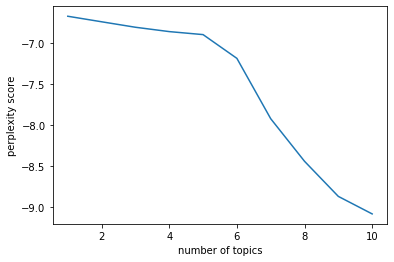

In [28]:
#perplexity 측정
perplexity_values=[]
for i in range(1,11):
    ii = i * 2
    
    print(i)
    ldamodel=models.LdaModel(corpus, num_topics=ii, id2word=dictionary, passes=15)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

x=range(1,11)
plt.plot(x, perplexity_values)
plt.xlabel("number of topics")
plt.ylabel("perplexity score")
plt.show()

1
2
3
4
5
6
7
8
9
10


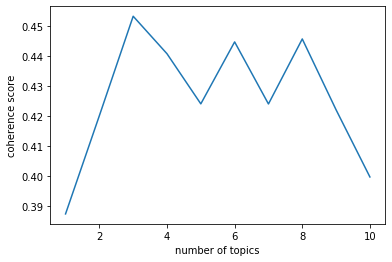

In [29]:

coherence_values=[]
for i in range(1,11):
    ii = i * 2
    print(i)
    ldamodel=models.LdaModel(corpus, num_topics=ii, id2word=dictionary, passes=15)
    coherence_model_lda=CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x=range(1,11)
plt.plot(x, coherence_values)
plt.xlabel("number of topics")
plt.ylabel("coherence score")
plt.show()

In [60]:
%%time
n_topics = 4 #토픽갯수 9개가 적정으로 보이나 혼잡도를 고려안하면 4개로 했을때 일관성이 더 높으므로 차후 시도 후 비교해볼것
# chunksize = 1800 #훈련모델에 사용되는 문서 갯수
passes = 20 #전체 학습 빈도 제어
iterations = 350 #각 문서의 반복횟수   passes와 iterations는 많을수록 좋으나 시간대비 성능값 확인 후 기입
lda = models.LdaModel(corpus, id2word = dictionary,\
                    alpha =0.9, passes= passes,\
                    iterations = iterations, num_topics = n_topics
                       

SyntaxError: unexpected EOF while parsing (<unknown>, line 8)

In [61]:
%%time
n_topics = 4 #토픽갯수 9개가 적정으로 보이나 혼잡도를 고려안하면 4개로 했을때 일관성이 더 높으므로 차후 시도 후 비교해볼것
# chunksize = 1800 #훈련모델에 사용되는 문서 갯수
passes = 20 #전체 학습 빈도 제어
iterations = 350 #각 문서의 반복횟수   passes와 iterations는 많을수록 좋으나 시간대비 성능값 확인 후 기입
lda = models.LdaModel(corpus, id2word = dictionary,\
                    alpha =0.9, passes= passes,\
                    iterations = iterations, num_topics = n_topics
                       )
corpus_lda = lda[corpus]

Wall time: 2min 11s


In [62]:
for i, topics in lda.show_topics(n_topics, formatted=False):
    print('topic', i+1, ':', ' '.join([t for t, _ in topics]))

topic 1 : 보다 박물관 정원 크다 연못 역사 거대하다 무료 나무 호수
topic 2 : 방문 하다 휴식 사람 자연 걷다 도보 녹색 숲 나무
topic 3 : 자전거 멋지다 타다 전망 걷기 산책 크다 호수 음식 달리기
topic 4 : 어린이 가족 가다 하다 시간 보내다 피크닉 산책 동물 가지다


In [55]:
%%time
n_topics = 4 #토픽갯수 9개가 적정으로 보이나 혼잡도를 고려안하면 4개로 했을때 일관성이 더 높으므로 차후 시도 후 비교해볼것
# chunksize = 1800 #훈련모델에 사용되는 문서 갯수
passes = 20 #전체 학습 빈도 제어
iterations = 350 #각 문서의 반복횟수   passes와 iterations는 많을수록 좋으나 시간대비 성능값 확인 후 기입
##시드값에 따른 토픽 차이 파악
for j in range(10,20):
    print('seed :', str(j))
    lda = models.LdaModel(corpus, id2word = dictionary,\
                       alpha =0.9, passes= passes,\
                       iterations = iterations, num_topics = n_topics,                                  random_state=j)
    for i, topics in lda.show_topics(n_topics, formatted=False):
        print('topic', i+1, ':', ' '.join([t for t, _ in topics]))
    print('\n')

seed : 10
topic 1 : 가다 하다 시간 보다 가족 걷다 보내다 방문 가지다 동물
topic 2 : 멋지다 어린이 활동 전망 음식 하다 주차 카페 놀이터 운동
topic 3 : 자전거 타다 산책 사람 휴식 하다 피크닉 도보 걷기 크다
topic 4 : 방문 박물관 정원 보다 크다 숲 하다 동물원 호수 역사


seed : 11
topic 1 : 자전거 하다 타다 산책 가다 사람 동물 걷기 피크닉 걷다
topic 2 : 어린이 가족 시간 보내다 가지다 하루 활동 친구 넓다 스포츠
topic 3 : 방문 하다 정원 사람 사진 역사 박물관 평화 거대하다 위치
topic 4 : 보다 멋지다 호수 크다 자연 나무 걷다 녹색 전망 박물관


seed : 12
topic 1 : 크다 호수 박물관 나무 정원 녹색 작다 숲 동물원 연못
topic 2 : 가족 산책 시간 보내다 휴식 피크닉 자연 하다 동물 하루
topic 3 : 자전거 하다 방문 타다 보다 걷다 가다 사람 도보 다니다
topic 4 : 멋지다 어린이 전망 활동 음식 무료 주차 카페 놀이터 야외


seed : 13
topic 1 : 자전거 타다 휴식 하다 활동 음식 걷다 주변 도보 다니다
topic 2 : 보다 사람 나무 자연 가다 사진 평화 찍다 살다 새
topic 3 : 어린이 가족 산책 시간 보내다 피크닉 동물 하다 하루 가다
topic 4 : 멋지다 방문 하다 박물관 정원 호수 전망 작다 크다 동물원


seed : 14
topic 1 : 자전거 타다 호수 걷기 하다 달리기 음식 보트 주차 동물원
topic 2 : 어린이 가족 시간 하다 보내다 산책 사람 피크닉 가다 가지다
topic 3 : 멋지다 걷다 크다 휴식 나무 전망 자연 녹색 작다 다니다
topic 4 : 방문 보다 하다 정원 박물관 사람 가다 사진 역사 거대하다


seed : 15
topic 1 : 자전거 타다 산책 크다 휴식 호수 자연 도보 걷기 나무
topic 2 : 방문 보다 박물관 정원 하다 사진 역사 거대하다 겨울 보이다

In [56]:
%%time
n_topics = 4 #토픽갯수 9개가 적정으로 보이나 혼잡도를 고려안하면 4개로 했을때 일관성이 더 높으므로 차후 시도 후 비교해볼것
# chunksize = 1800 #훈련모델에 사용되는 문서 갯수
passes = 20 #전체 학습 빈도 제어
iterations = 350 #각 문서의 반복횟수   passes와 iterations는 많을수록 좋으나 시간대비 성능값 확인 후 기입
##시드값에 따른 토픽 차이 파악
for j in range(20,40):
    print('seed :', str(j))
    lda = models.LdaModel(corpus, id2word = dictionary,\
                       alpha =0.9, passes= passes,\
                       iterations = iterations, num_topics = n_topics,                                  random_state=j)
    for i, topics in lda.show_topics(n_topics, formatted=False):
        print('topic', i+1, ':', ' '.join([t for t, _ in topics]))
    print('\n')

seed : 20
topic 1 : 자전거 타다 하다 가족 산책 시간 보내다 피크닉 휴식 하루
topic 2 : 방문 호수 박물관 하다 크다 동물원 사람 역사 숲 위치
topic 3 : 멋지다 보다 방문 하다 전망 자연 가다 사진 정원 평화
topic 4 : 어린이 크다 나무 가다 걷다 가지다 동물 넓다 다니다 녹색


seed : 21
topic 1 : 자전거 하다 타다 가다 사람 걷다 보다 도보 방문 걷기
topic 2 : 방문 박물관 하다 보다 무료 동물원 역사 거대하다 크다 위치
topic 3 : 어린이 가족 산책 보내다 휴식 피크닉 시간 동물 활동 하루
topic 4 : 멋지다 호수 나무 정원 자연 전망 보다 작다 녹색 크다


seed : 22
topic 1 : 하다 자전거 타다 방문 보다 가다 사람 걷다 시간 다니다
topic 2 : 박물관 정원 전망 제공 무료 역사 거대하다 위치 방문 식물
topic 3 : 멋지다 가족 산책 피크닉 보내다 휴식 활동 친구 스포츠 음식
topic 4 : 크다 어린이 호수 자연 나무 동물 녹색 넓다 동물원 숲


seed : 23
topic 1 : 하다 자전거 타다 방문 가다 시간 걷다 보내다 사람 산책
topic 2 : 멋지다 나무 정원 전망 녹색 보다 연못 크다 산책로 여름
topic 3 : 호수 박물관 보다 크다 동물원 숲 사진 역사 거대하다 방문
topic 4 : 어린이 가족 휴식 피크닉 활동 친구 산책 동물 걷기 스포츠


seed : 24
topic 1 : 하다 가다 사람 방문 자연 보다 사진 찾다 앉다 걷다
topic 2 : 보다 멋지다 박물관 정원 전망 나무 방문 크다 역사 거대하다
topic 3 : 자전거 타다 산책 호수 크다 걷다 도보 멋지다 걷기 녹색
topic 4 : 어린이 가족 시간 보내다 동물 피크닉 활동 하루 친구 휴식


seed : 25
topic 1 : 박물관 정원 크다 나무 호수 방문 사진 숲 역사 위치
topic 2 : 멋지다 보다 하다 방문 가다 전망 사람 자연 오다 평화
top

In [64]:
# 연구에 활용된 토픽결과
for i, topics in lda.show_topics(n_topics, formatted=False):
    print('topic', i+1, ':', ' '.join([t for t, _ in topics]))

topic 1 : 사람 가다 자연 나무 걷다 녹색 숲 도보 휴식 찾다
topic 2 : 방문 하다 박물관 정원 보다 사진 크다 역사 동물원 위치
topic 3 : 자전거 멋지다 타다 산책 하다 보다 전망 동물 걷다 호수
topic 4 : 어린이 가족 시간 보내다 하루 활동 친구 하다 음식 주차


In [65]:
doc_weights_init = np.zeros((len(corpus_lda), n_topics))
for i in tqdm(range(len(corpus_lda))):
    topics = corpus_lda[i]
    for j, prob in topics:
        doc_weights_init[i, j] = prob

100%|██████████████████████████████████████████████████████████████████████████| 24778/24778 [00:04<00:00, 5000.60it/s]


In [66]:
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\data.npy', data)
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\word_vectors.npy', word_vectors)
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\unigram_distribution.npy', unigram_distribution)
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\decoder.npy', decoder)
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\doc_decoder.npy', doc_decoder)
np.save(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\doc_weights_init.npy', doc_weights_init)
#이 과정이 끝나면 train.py 실행해서 학습 진행   토픽갯수에 따라 하이퍼 파라미터 수정해줘야함

# 위 과정 이후 학습까지 끝내면 아래과정 진행

In [6]:
####아래부터 학습이 끝난 데이터로 진행
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline

# https://github.com/DmitryUlyanov/Multicore-TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE


Bad key "text.kerning_factor" on line 4 in
C:\Users\rhkdz\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
def softmax(x):
    # x has shape [batch_size, n_classes]
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

from matplotlib import font_manager, rc
# 한글폰트 깨짐문제 해결하기. 아래 코드의 경우 나눔바른고딕 적용
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumBarunGothic.ttf").get_name()
rc('font', family=font_name)

In [77]:
## 학습된 데이터 불러오기
state = torch.load(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\model_state.pytorch', map_location=lambda storage, loc: storage)
n_topics = 4
doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
resulted_word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()
decoder = np.load(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\decoder.npy',allow_pickle=True)[()]
doc_decoder = np.load(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\doc_decoder.npy',allow_pickle=True)[()]
# distribution over the topics for each document
topic_dist = softmax(doc_weights)

# vector representation of the documents
doc_vecs = np.matmul(topic_dist, topic_vectors)

#토픽 결과보기
similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

topic 1 : 사람 평화 쉬다 자연 나무 느끼다 평온 앉다 공기 소리
topic 2 : 박물관 정원 역사 건물 방문 작품 성 흥미 전시회 예술
topic 3 : 타다 자전거 달리기 빌리다 걷기 산책 조깅 멋지다 보트 바다
topic 4 : 어린이 가족 시설 게임 놀이터 음식 활동 놀이 야외 욕실


In [78]:
#lda2vec이 끝난 문서에 대해 각 토픽별 target 부여
target = []
target_names = []
for i in range(len(doc_decoder)):
    for j in reversed(topic_dist[i].argsort()[-1:]):
        tag = 'topic' + str(j + 1)
        if tag not in target_names:
            target_names.append(tag)
        target.append(j)
        
targets = np.array(target, dtype = 'int64')
target_names.sort(reverse = False)
# targets = np.array([targets[doc_decoder[i]] for i in range(len(doc_decoder))])
print(targets[:10],target_names)

[0 1 0 1 0 0 1 1 0 1] ['topic1', 'topic2', 'topic3', 'topic4']


In [86]:
print(len(targets))

24778


In [87]:
print(doc_decoder)

 69311, 23350: 69321, 23351: 69323, 23352: 69324, 23353: 69327, 23354: 69328, 23355: 69329, 23356: 69331, 23357: 69335, 23358: 69336, 23359: 69338, 23360: 69340, 23361: 69341, 23362: 69351, 23363: 69354, 23364: 69357, 23365: 69360, 23366: 69365, 23367: 69366, 23368: 69369, 23369: 69372, 23370: 69376, 23371: 69377, 23372: 69379, 23373: 69390, 23374: 69391, 23375: 69395, 23376: 69397, 23377: 69399, 23378: 69400, 23379: 69401, 23380: 69404, 23381: 69405, 23382: 69412, 23383: 69413, 23384: 69418, 23385: 69419, 23386: 69420, 23387: 69429, 23388: 69434, 23389: 69435, 23390: 69437, 23391: 69442, 23392: 69450, 23393: 69451, 23394: 69453, 23395: 69463, 23396: 69466, 23397: 69472, 23398: 69473, 23399: 69474, 23400: 69475, 23401: 69481, 23402: 69488, 23403: 69497, 23404: 69504, 23405: 69514, 23406: 69515, 23407: 69516, 23408: 69519, 23409: 69522, 23410: 69524, 23411: 69527, 23412: 69531, 23413: 69532, 23414: 69534, 23415: 69535, 23416: 69541, 23417: 69543, 23418: 69546, 23419: 69547, 23420: 69549

In [80]:
# targets의 숫자들을 topic 명칭으로 변경
topics = []
for i in range(len(doc_decoder)):
    topics.append(target_names[targets[i]])
print(topics[:10])

['topic1', 'topic2', 'topic1', 'topic2', 'topic1', 'topic1', 'topic2', 'topic2', 'topic1', 'topic2']


In [81]:
#토픽별로 출현빈도 합산
print('DISTRIBUTION OVER TOPICS:')
topicdict = dict()
for i in range(len(doc_decoder)):
    for j, p in enumerate(topic_dist[i], 1):
        topicdict[j] = topicdict.get(j, 0) + p
print(topicdict)

DISTRIBUTION OVER TOPICS:
{1: 6187.162461086176, 2: 6322.339860595763, 3: 6113.237362860586, 4: 6155.260307838558}


In [82]:
#각 토픽별 문서 분포 퍼센트
total = 0
topicpercent = dict()
for v in topicdict.values():
    total += v
    print(total)

for k in topicdict.keys():
    percent = topicdict[k]/total*100
    topicpercent[k] = percent
print(topicpercent)



6187.162461086176
12509.502321681939
18622.739684542525
24777.999992381083
{1: 24.970386887515737, 2: 25.515941006295108, 3: 24.67203714884304, 4: 24.84163495734612}


In [83]:
print(topicdict.values())

dict_values([6187.162461086176, 6322.339860595763, 6113.237362860586, 6155.260307838558])


In [84]:
topiccon = []
topicdoc = []
topiccity, topicarea, topicgdp, topictemper = [], [], [], []
for idx in range(len(doc_decoder)):
    topicdoc.append(tokenized_docs[doc_decoder[idx]])
    topiccon.append(continentlist[doc_decoder[idx]])
    topiccity.append(citylist[doc_decoder[idx]])
    topicarea.append(arealist[doc_decoder[idx]])
    topicgdp.append(gdplist[doc_decoder[idx]])
    topictemper.append(temperaturelist[doc_decoder[idx]])
print(topicdoc[:3], '\n',len(topicdoc), '\n', topiccon[:3])

[(0, ['봄', '가다', '나들이', '주위', '보이다', '나열', '고층 건물', '여유', '보이다', '자연', '조합', '쉽다', '누리다', '힐링', '선사', '가족', '연인', '친구', '방문', '하다']), (1, ['언어의 정원', '언어의 정원', '정자', '남서쪽', '정자', '보다', '입장료', '예쁘다', '동쪽', '프랑스', '정원', '보다', '식물', '온실']), (2, ['입장권', '놀라다', '관리', '언어의 정원', '배경', '넓다', '잔디', '휴식', '오시', '연관', '회원권'])] 
 24778 
 [(0, '아시아'), (1, '아시아'), (2, '아시아')]


In [85]:
%%time
#lda2vec 결과물을 바탕으로 문서당 토픽정보 입력
conn = sqlite3.connect(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\crawler9.sqlite')
cur = conn.cursor()

cur.executescript('''
    CREATE TABLE IF NOT EXISTS Result (
        id            INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
        review        TEXT NOT NULL UNIQUE,
        topic_id      INTEGER,
        continent_id  INTEGER,
        city_id       INTEGER   
    );

    CREATE TABLE IF NOT EXISTS Result_con (
        id          INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
        fivecon     TEXT NOT NULL UNIQUE
    );

    CREATE TABLE IF NOT EXISTS Result_city (
        id          INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
        city        TEXT NOT NULL UNIQUE,
        area        INTEGER,
        gdp         INTEGER,
        temperature INTEGER
    );
        
    CREATE TABLE IF NOT EXISTS Result_topic (
        id      INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
        topic    TEXT NOT NULL UNIQUE
    )

    ''')

for i in range(len(doc_decoder)):
    topic = topics[i];
    review = str(topicdoc[i][1]).replace('[','').replace(']','').replace('\'','');
    fivecon = str(topiccon[i][1]);
    city = str(topiccity[i][1]);
    area = int(topicarea[i][1]);
    gdp = int(topicgdp[i][1]);
    temperature = int(topictemper[i][1]);
    cur.execute('''INSERT OR IGNORE INTO Result_topic (topic) 
        VALUES ( ? )''', (topic, ))
    cur.execute('SELECT id FROM Result_topic WHERE topic = ? ', (topic, ))
    topic_id = cur.fetchone()[0]

    cur.execute('''INSERT OR IGNORE INTO Result_con (fivecon) 
        VALUES ( ? )''', (fivecon, ))
    cur.execute('SELECT id FROM Result_con WHERE fivecon = ? ', (fivecon, ))
    continent_id = cur.fetchone()[0]

    cur.execute('''INSERT OR IGNORE INTO Result_city (city, area, gdp, temperature) 
        VALUES ( ?, ?, ?, ? )''', (city, area, gdp, temperature))
    cur.execute('SELECT id FROM Result_city WHERE city = ? ', (city, ))
    city_id = cur.fetchone()[0]

    cur.execute('''INSERT OR REPLACE INTO Result (review, topic_id, continent_id, city_id) 
        VALUES (?, ?, ?, ?)''', (review, topic_id, continent_id, city_id) )
    conn.commit()
conn.close()

Wall time: 3min 30s


In [ ]:
# 조건에 따라서 필터링하는것
'''
SELECT Result.review, Result_topic.topic, Result_city.city, Result_city.temperature
FROM Result JOIN Result_city, Result_topic
ON Result.city_id = Result_city.id AND Result.topic_id = Result_topic.id
WHERE Result_city.temperature < 1000 AND Result_topic.topic = 'topic1'
'''

In [88]:
len(doc_decoder)

24778

In [ ]:
### 특정 토픽이 가장 우세한 문서들만 불러오기
conn = sqlite3.connect(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\crawler9.sqlite')
cur = conn.cursor()

#저장할 토픽에 맞게 topic_id 수정
cur.execute('''
    SELECT review, topic_id
    FROM Result 
    WHERE topic_id = 20
    ''')
line = ''
sep = ', '
sepplace = '//'
ex_place = None
docs = []
textdummy = []
for row in cur:
    text = row[0]
    test = text.split(sep)
    for xx in test :
        textdummy.append(xx)


conn.close()

In [ ]:
from collections import Counter

# 문서에서 단어 출현빈도 파악해서 DB에 저장
conn = sqlite3.connect(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\crawler8.sqlite')

cur = conn.cursor()

# Count_topic 뒤 숫자 변경 필요
cur.executescript('''
    CREATE TABLE IF NOT EXISTS Count_topic2 (
        id          INTEGER PRIMARY KEY AUTOINCREMENT UNIQUE,
        word        TEXT NOT NULL UNIQUE,
        count       INTEGER
    )

    ''')
cnt = Counter(textdummy)
dddd = cnt.most_common()
for line in dddd:
    word = line[0];
    count = line[1];

    cur.execute('''REPLACE INTO Count_topic2 (word, count)
            VALUES (?, ?)''',(word, count))
    conn.commit()
conn.close()

In [ ]:
def plot(X):
    # X has shape [n_documents, 2]
    
    plt.figure(figsize=(16, 9), dpi=120);
    cmap = plt.cm.tab20
    number_of_targets = 4
    
    for i in range(number_of_targets):
        
        label = target_names[i]
        size = 15.0
        linewidths = 0.5
        edgecolors = 'k'
        color = cmap(i)
        
        if 'topic 1' in label:
            marker = 'x'
        elif 'topic 2' in label:
            marker = 's'
            edgecolors = 'b'
        elif 'topic 3' in label:
            marker = 'o'
            edgecolors = 'g'
        elif 'topic 4' in label:
            marker = 'P'
            size = 17.0
        elif 'topic 5' in label:
            marker = 'o'
            size = 14.0
            edgecolors = 'k'
            linewidths = 1.0
        elif 'topic 6' in label:
            marker = 'P'
            size = 18.0
            edgecolors = 'r'
            linewidths = 0.5
        else:
            marker = 'v'
            edgecolors = 'm'
        
        plt.scatter(
            X[targets == i, 0], 
            X[targets == i, 1], 
            s=size, c=color, marker=marker,
            linewidths=linewidths, edgecolors=edgecolors,
            label=label
        );
    
    leg = plt.legend()
    leg.get_frame().set_alpha(0.3)

In [ ]:
tsne = TSNE(perplexity=200, n_jobs=4)
X = tsne.fit_transform(doc_vecs.astype('float64'))

plot(X)  # learned document vectors

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better


In [ ]:
doc_weights_init = np.load('doc_weights_init.npy')
tsne = TSNE(perplexity=200, n_jobs=4)
Y = tsne.fit_transform(doc_weights_init.astype('float64'))
# to initialize topic assignments for lda2vec algorithm 
# I run normal LDA and used output distributions over topics 
# of each document

plot(Y)  # distribution over the topics for each document (output of LDA)

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

In [ ]:
tsne = TSNE(perplexity=200, n_jobs=4)
Z = tsne.fit_transform(topic_dist.astype('float64'))

plot(Z)  # learned distribution over the topics for each document

# these are topic assignments as on the plot above 
# but these ones are after the training of lda2vec

# different colors and markers represent 
# ground truth labels of each document

# open this image in new tab to see it better

In [ ]:
# distribution of nonzero probabilities
dist = topic_dist.reshape(-1)
plt.hist(dist[dist > 0.01], bins=40);

In [ ]:
# distribution of probabilities for first topic
plt.hist(topic_dist[:, 0], bins=40);

In [ ]:
# distribution of probabilities for second topic
plt.hist(topic_dist[:, 1], bins=40);

In [ ]:
# correlation of topic assignments
corr = np.corrcoef(topic_dist.transpose(1, 0))
plt.imshow(corr);
plt.colorbar();

In [ ]:
i = 1 # document id

print('DOCUMENT:')
print([doc for j, doc in docs if j == doc_decoder[i]][0], '\n')

print('DISTRIBUTION OVER TOPICS:')
s = ''
for j, p in enumerate(topic_dist[i], 1):
    s += '{0}:{1:.3f}  '.format(j, p)
    if j%6 == 0:
        s += '\n'
print(s)

print('\nTOP TOPICS:')
for j in reversed(topic_dist[i].argsort()[-1:]):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

In [89]:
## 카이제곱검정 구현
from pandas import DataFrame

Asia, Africa, Europe, America, Oceania = [25, 27, 13, 35], [20, 14, 18, 47], [26, 30, 27, 17], [23, 23, 28, 26], [19, 23, 38, 20]
xc = DataFrame([Asia, Africa, Europe, America, Oceania], columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'], index=['Asia', 'Africa', 'Europe', 'America', 'Oceania'])
xc

,Topic 1,Topic 2,Topic 3,Topic 4
Asia,25,27,13,35
Africa,20,14,18,47
Europe,26,30,27,17
America,23,23,28,26
Oceania,19,23,38,20


In [98]:
## 카이제곱검정 구현
from pandas import DataFrame

xo, xe = [26, 27, 27, 20], [21, 24, 18, 36]
xc = DataFrame([xo, xe], columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'], index=['High', 'Low'])
xc

,Topic 1,Topic 2,Topic 3,Topic 4
High,26,27,27,20
Low,21,24,18,36


In [91]:
#대륙별 카이제곱검정
from scipy.stats import chi2_contingency
data = [[25, 27, 13, 35], [20, 14, 18, 47], [26, 30, 27, 17], [23, 23, 28, 26], [19, 23, 38, 20]]
chi2, pval, dof, expected = chi2_contingency(data)
print(chi2, pval, dof, expected)

43.524353419235524 1.8398951443654767e-05 12 [[22.64529058 23.44689379 24.8496994  29.05811623]
 [22.41883768 23.21242485 24.6012024  28.76753507]
 [22.64529058 23.44689379 24.8496994  29.05811623]
 [22.64529058 23.44689379 24.8496994  29.05811623]
 [22.64529058 23.44689379 24.8496994  29.05811623]]


In [30]:
from scipy.stats import chi2_contingency
# data = [[29, 19, 31, 20], [24, 29, 24, 23], [18, 18, 17, 46]] #기온별
# data = [[26, 27, 27, 20], [21, 24, 18, 36]] # gdp별인데 이건 카이제곱으로 대체
data = [[20, 22, 29, 29], [22, 27, 19, 32], [26, 26, 26, 22]] #면적별
# data = [[25, 27, 13, 35], [20, 14, 18, 47], [26, 30, 27, 17], [23, 23, 28, 26], [19, 23, 38, 20]] # 대륙별
chi2_num, pval, dof, expected = chi2_contingency(data)
print(chi2_num, pval, dof, '\n',expected)

5.422279004731166 0.49089966497818904 6 
 [[22.66666667 25.         24.66666667 27.66666667]
 [22.66666667 25.         24.66666667 27.66666667]
 [22.66666667 25.         24.66666667 27.66666667]]


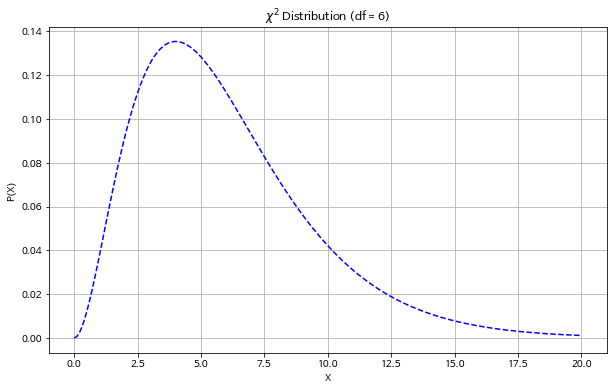

In [19]:
from numpy import linspace
from scipy.stats import chi2

df = dof         # 자유도
x = linspace(0, 20, 201)
y = chi2(df).pdf(x)
df_title = 'df =' + ' ' + str(df)
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution ('+df_title+')')
plt.show()

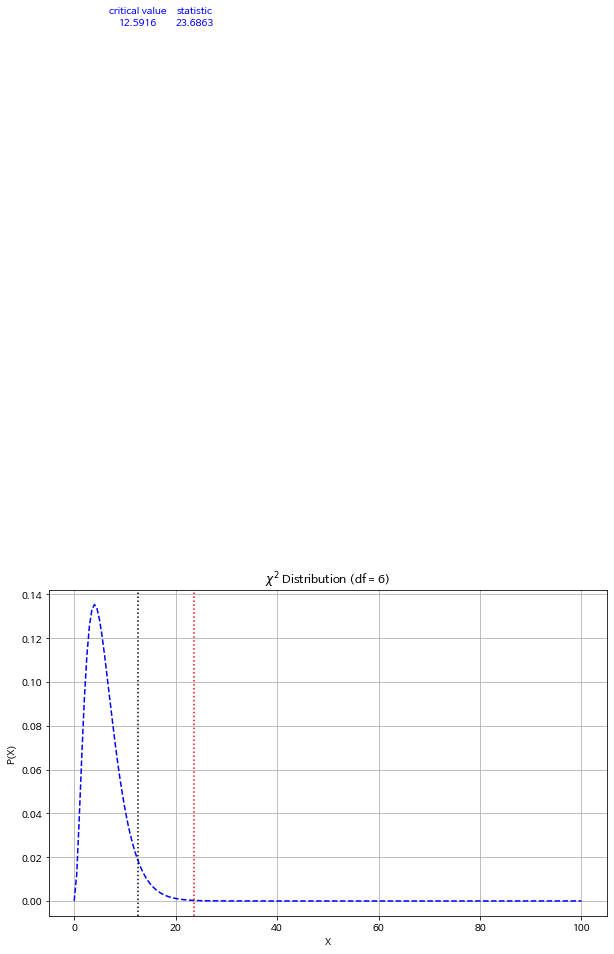

In [29]:
from numpy import linspace
from scipy.stats import chi2
df = dof         # 자유도
x = linspace(0, 100, 201)
y = chi2(df).pdf(x)
df_title = 'df =' + ' ' + str(df)
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .4, 'critical value\n' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

plt.axvline(x=chi2_num, color='r', linestyle=':')
plt.text(chi2_num, .4, 'statistic\n' + str(round(chi2_num, 4)), 
         horizontalalignment='center', color='b')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution ('+df_title+')')
plt.show()

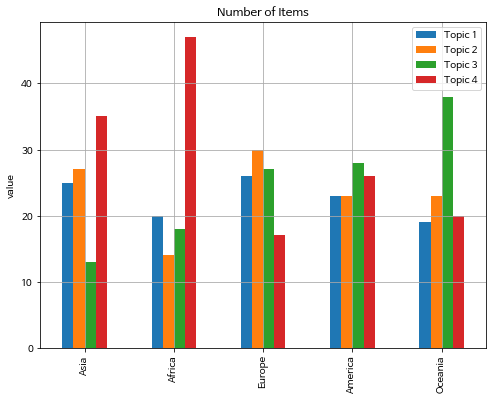

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = xc.plot(kind='bar', title='Number of Items', figsize=(8, 6))
ax.set_ylabel('value')
plt.grid(color='darkgray')
plt.show()

In [12]:
#카이제곱검정
from pandas import DataFrame

xo, xe = [26, 27, 27, 20], [21, 24, 18, 36]
xc = DataFrame([xo, xe], columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'], index=['High', 'Low'])
result = chisquare(xo, f_exp=xe)
result 

,Topic 1,Topic 2,Topic 3,Topic 4
High,26,27,27,20
Low,21,24,18,36


Power_divergenceResult(statistic=13186.404615384614, pvalue=0.0)
Power_divergenceResult(statistic=2789.2748717948716, pvalue=0.0)
Power_divergenceResult(statistic=20967.357948717952, pvalue=0.0)
Power_divergenceResult(statistic=17059.044615384617, pvalue=0.0)
Power_divergenceResult(statistic=1676.0441025641026, pvalue=0.0)
Power_divergenceResult(statistic=37296.21435897436, pvalue=0.0)
Power_divergenceResult(statistic=18381.911794871798, pvalue=0.0)
Power_divergenceResult(statistic=6670.262051282051, pvalue=0.0)
Power_divergenceResult(statistic=16686.53230769231, pvalue=0.0)
Power_divergenceResult(statistic=32321.331794871796, pvalue=0.0)


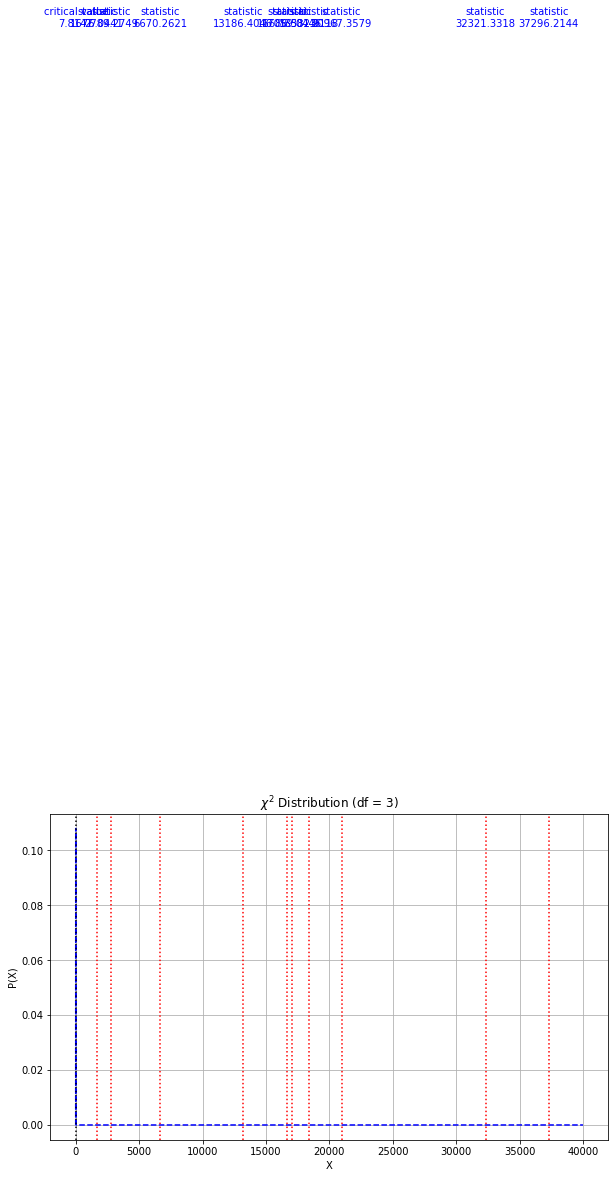

In [68]:
#gdp별 카이제곱검정
from numpy import linspace
from scipy.stats import chi2
from scipy.stats import chisquare
df = 3          # 자유도
x = linspace(0, 40000, 10000)
y = chi2(df).pdf(x)
x95 = chi2(df).ppf(.95)
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .4, 'critical value\n' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

with open(r'C:\Users\rhkdz\OneDrive\바탕 화면\py4e\구글리뷰크롤링\lda2vec\forchi2.txt') as fh:
    ob_text = fh.read()
    ob_text = ob_text.split('\n')
    for line in ob_text:
        xo = map(int, line.split())
        xo = list(xo)
        xe = [xo[0]*0.24, xo[1]*0.26, xo[2]*0.24, xo[3]*0.26]
        result = chisquare(xo, f_exp=xe)
        print(result)
        plt.axvline(x=result[0], color='r', linestyle=':')
        plt.text(result[0], .4, 'statistic\n' + str(round(result[0], 4)), 
                    horizontalalignment='center', color='b')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (df = 3)')
plt.show()        


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .4, 'critical value\n' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

plt.axvline(x=result[0], color='r', linestyle=':')
plt.text(result[0], .4, 'statistic\n' + str(round(result[0], 4)), 
         horizontalalignment='center', color='b')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (df = 3)')
plt.show()

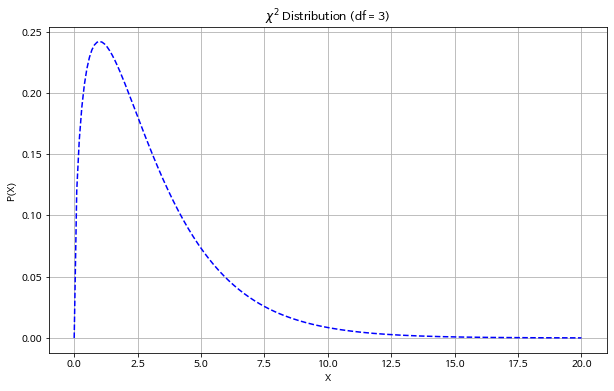

In [14]:
from numpy import linspace
from scipy.stats import chi2

df = 3          # 자유도
x = linspace(0, 20, 201)
y = chi2(df).pdf(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (df = 3)')
plt.show()

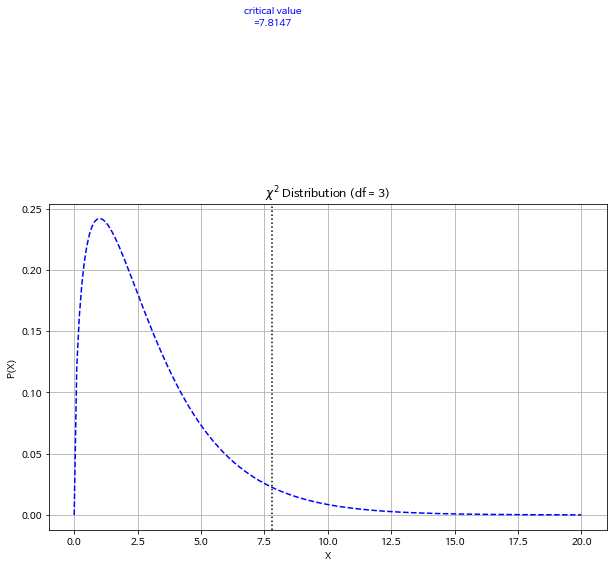

In [15]:
x95 = chi2(df).ppf(.95)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')

plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .4, 'critical value\n=' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (df = 3)')
plt.show()

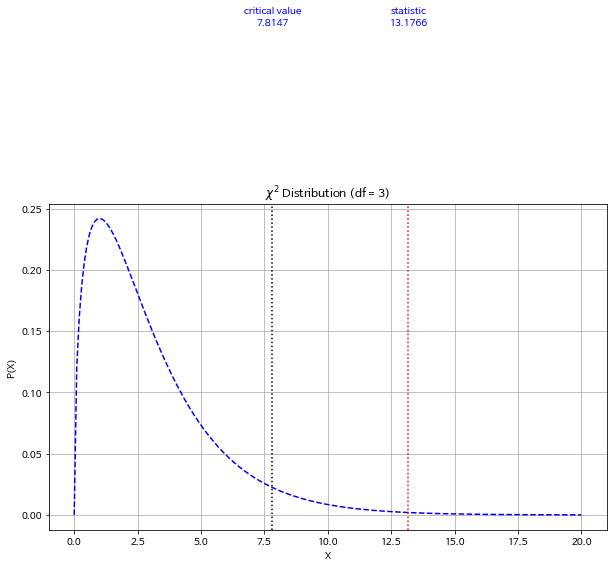

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b--')
plt.axvline(x=x95, color='black', linestyle=':')
plt.text(x95, .4, 'critical value\n' + str(round(x95, 4)), 
         horizontalalignment='center', color='b')

plt.axvline(x=result[0], color='r', linestyle=':')
plt.text(result[0], .4, 'statistic\n' + str(round(result[0], 4)), 
         horizontalalignment='center', color='b')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (df = 3)')
plt.show()

In [119]:
#GDP별 카이제곱검정
from pandas import DataFrame

xo, xe = [4424, 4467, 4426, 3357], [1762, 1968, 1516, 3014]
xc = DataFrame([xo, xe], columns=['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4'], index=['High', 'Low'])
xc

,Topic 1,Topic 2,Topic 3,Topic 4
High,4424,4467,4426,3357
Low,1762,1968,1516,3014


<h1> 범주간 동질성 검사를 위한 이원 카이제곱검정

In [120]:
# 동질성 검사를 위한 이원 카이제곱
from scipy.stats import chi2_contingency
from pandas import DataFrame

# gdp비교
data = [[4424, 4467, 4426, 3357], [1762, 1968, 1516, 3014]]
chi2, p, dof, expected = chi2_contingency(data)

msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))
print(expected)

Test Statistic: 812.8455489999928
p-value: 7.084498274979479e-176
Degree of Freedom: 3
[[4136.73554183 4303.24817518 3973.56653565 4260.44974733]
 [2049.26445817 2131.75182482 1968.43346435 2110.55025267]]


In [121]:
# 동질성 검사를 위한 이원 카이제곱
from scipy.stats import chi2_contingency
from pandas import DataFrame
# 면적별 비교
data = [[591, 663, 853, 854], [1644, 2003, 1431, 2406], [3751, 3769, 3658, 3111]]
chi2, p, dof, expected = chi2_contingency(data)

msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))
print(expected)

Test Statistic: 415.1421221463396
p-value: 1.5506781297783307e-86
Degree of Freedom: 6
[[ 716.60653352  770.35800922  711.33912833  762.69632894]
 [1811.24055955 1947.09873049 1797.92706396 1927.73364599]
 [3458.15290693 3717.54326029 3432.73380771 3680.57002507]]


In [123]:
# 동질성 검사를 위한 이원 카이제곱
from scipy.stats import chi2_contingency
from pandas import DataFrame

# 평균기온별 비교
data = [[1036, 682, 1106, 720], 
[4341, 5120, 4236, 4053], 
[609, 633, 600, 1598]
]
chi2, p, dof, expected = chi2_contingency(data)

msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))
print(expected)

Test Statistic: 1101.3332969869589
p-value: 1.073589068197894e-234
Degree of Freedom: 6
[[ 857.70130185  922.03606372  851.39678176  912.86585267]
 [4295.76696046 4617.98536428 4264.19099216 4572.05668311]
 [ 832.53173769  894.97857201  826.41222609  886.07746422]]


In [124]:
# 동질성 검사를 위한 이원 카이제곱
from scipy.stats import chi2_contingency
from pandas import DataFrame

# 대륙별 비교
data = [[1470, 1611, 786, 2072], 
[256, 181, 223, 596], 
[2400, 2749, 2543, 1558], 
[1722, 1726, 2109, 1996], 
[138, 168, 281, 149]
]
chi2, p, dof, expected = chi2_contingency(data)

msg = 'Test Statistic: {}\np-value: {}\nDegree of Freedom: {}'
print(msg.format(chi2, p, dof))
print(expected)

Test Statistic: 1364.5432562257456
p-value: 6.123387921726375e-285
Degree of Freedom: 12
[[1437.32732271 1545.13887766 1426.76227056 1529.77152907]
 [ 303.97089027  326.77124606  301.73655697  323.5213067 ]
 [2238.63912024 2406.55575321 2222.18403817 2382.62108838]
 [1827.93959732 1965.05033557 1814.5033557  1945.50671141]
 [ 178.12306946  191.4837875   176.8137786   189.57936444]]
